In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
%matplotlib notebook 

In [3]:
os.chdir('..')

In [4]:
os.getcwd()

'/home/suraj/Projects/Respiratory-Rate-Estimation'

In [5]:
col_arr = [0]*54
for i in range(0,54):
    col_arr[i] = i

path1 ='data/Day1/Post/DataFeatures1.csv'
path2 ='data/Day2/Post1/DataFeatures2.csv' 
path3 ='data/Day2/Post2/DataFeatures.csv' 
path4 ='data/Day3/Post/DataFeatures4.csv'
path5 ='data/Day4/Post/DataFeatures.csv'

df1=(pd.read_csv(path1 ,header = None, usecols = col_arr))
df2=(pd.read_csv(path2 ,header = None, usecols = col_arr))
df3=(pd.read_csv(path3 ,header = None, usecols = col_arr))
df4=(pd.read_csv(path4 ,header = None, usecols = col_arr))
df5=(pd.read_csv(path5 ,header = None, usecols = col_arr))

In [6]:
df1 = np.array(df1)
df2 = np.array(df2)
df3 = np.array(df3)
df4 = np.array(df4)
df5 = np.array(df5)

In [7]:
df = np.concatenate((df1, df2, df3, df4, df5))
df = pd.DataFrame(df)
df = df.fillna(0)

In [8]:
f = [i for i in range(1, 53)]
y = df[53]
x = df[f]
x = np.array(x)
y = np.array(y)
y = np.expand_dims(y, axis=1)

x = x[:-520]
y = y[:-520]

In [9]:
print(x.shape)
print(y.shape)

(115098, 52)
(115098, 1)


<IPython.core.display.Javascript object>


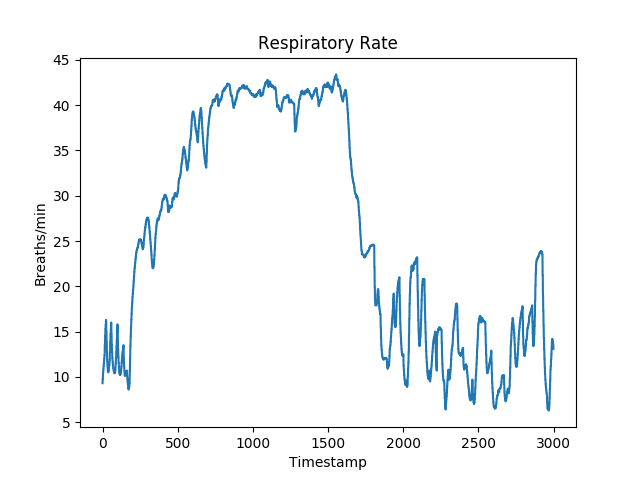

In [11]:
plt.plot(y[0:3000])
plt.xlabel('Timestamp')
plt.ylabel('Breaths/min')
plt.title('Respiratory Rate')
plt.savefig('assets/fig1.png')

In [ ]:
y_1d = y[:,0]
thresh = 5
grad = np.gradient(y_1d)
abs_grad = np.absolute(grad)
for i in range(abs_grad.shape[0]):
    if(abs_grad[i] < thresh):
        abs_grad[i] = 0

In [ ]:
plt.plot(abs_grad)

In [ ]:
pca = PCA()
pca.fit(x)
print(pca.explained_variance_ratio_)
print("\n")
print(pca.explained_variance_ratio_.cumsum())

In [ ]:
n_components = 12
pca = PCA(n_components=n_components)
pca.fit(x)
x_pca = pca.transform(x)
print(x_pca.shape)

In [ ]:
scalerX = StandardScaler()
scalerX.fit(x_pca)
x_scaled = scalerX.transform(x_pca)

In [ ]:
scalerY = StandardScaler()
scalerY.fit(y)
y_scaled = scalerY.transform(y)

In [ ]:
X = x_scaled
Y = y_scaled

In [ ]:
split = 0.10
len_train = int( X.shape[0]*(1-split) )
len_CV = int(X.shape[0]*split)
x_train = X[0:len_train]
y_train = Y[0:len_train]
x_CV = X[len_train: ]
y_CV = Y[len_train: ]

print(x_train.shape)
print(y_train.shape)
print(x_CV.shape)
print(y_CV.shape)

In [ ]:
num_features = x_train.shape[1]

Training a simple Neural Net model to reduce the number of dimensions from 29 to 1

In [ ]:
batch_size = 8
epochs = 20
modelPreTrained = []

if(not os.path.isfile('modelPreTrained.json')):
    modelPreTrained = Sequential()
    modelPreTrained.add(Dense(64, input_dim=num_features, activation='relu' ))
    modelPreTrained.add(Dropout(0.2)) 
    modelPreTrained.add(Dense(32, activation='relu'))
    modelPreTrained.add(Dropout(0.2)) 
    modelPreTrained.add(Dense(8, activation='relu'))
    modelPreTrained.add(Dropout(0.2)) 
    modelPreTrained.add(Dense(1))
    print('Created new model') 
else:
    json_file = open('modelPreTrained.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    modelPreTrained = model_from_json(loaded_model_json)
    modelPreTrained.load_weights("modelPreTrained.h5")
    print("Loaded modelPreTrained from disk")     

modelPreTrained.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
hist_obj = modelPreTrained.fit(x_train, y_train, validation_data=[x_CV, y_CV], epochs=epochs, batch_size=batch_size)

In [ ]:
modelPreTrained_json = modelPreTrained.to_json()
with open("modelPreTrained.json", "w") as json_file:
    json_file.write(modelPreTrained_json)
# serialize weights to HDF5
modelPreTrained.save_weights("modelPreTrained.h5")
print("Saved modelPreTrained to disk")

In [ ]:
train_loss = hist_obj.history['loss']
train_mse = hist_obj.history['mean_squared_error']
val_loss = hist_obj.history['val_loss']
val_mse = hist_obj.history['val_mean_squared_error']

In [ ]:
fig1 = plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train','Val'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

In [ ]:
fig2 = plt.figure()
plt.plot(train_mse)
plt.plot(val_mse)
plt.legend(['Train','Val'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model MSE')
plt.show()

In [ ]:
y_pred_CV = modelPreTrained.predict(x_CV)

In [ ]:
prediction = scalerY.inverse_transform(y_pred_CV)
original = scalerY.inverse_transform(y_CV)
print(mean_squared_error(original, prediction))

In [ ]:
plt.plot(original)
#plt.plot(prediction)

LSTM implementation

In [ ]:
X_train = x_train #modelPreTrained.predict(x_train)
Y_train = y_train

X_CV = x_CV#modelPreTrained.predict(x_CV)
Y_CV = y_CV
look_back = 20

In [ ]:
print(X_train.shape)
print(X_CV.shape)

len_train = X_train.shape[0]
len_CV = X_CV.shape[0]

In [ ]:
len_train = X_train.shape[0]
len_CV = X_CV.shape[0]
print(X_train.shape)
print(Y_train.shape)
print(X_CV.shape)
print(Y_CV.shape)


In [ ]:
trainX, trainY = [], []
testX, testY = [], []

for i in range(0,len_train-look_back):
    trainX.append(X_train[i:i+look_back, :])
    trainY.append(Y_train[i+look_back, 0])

for i in range(0,len_CV-look_back):
    testX.append(X_CV[i:i+look_back, :])
    testY.append(Y_CV[i+look_back, 0])
    
    
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

input_dims = trainX.shape[2]

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(input_dims)

In [ ]:
model = []
if(not os.path.isfile('model.json')):
    model = Sequential()
    model.add(LSTM(64, input_shape=[None, input_dims]))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    print('Created new model') 
else:
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("model.h5")
    print("Loaded model from disk")     

model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mse'])
model.summary()

In [ ]:
hist_obj = model.fit(trainX, trainY, validation_data=[testX, testY], epochs=10, batch_size=8, verbose=1)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
train_loss = hist_obj.history['loss']
train_mse = hist_obj.history['mean_squared_error']
val_loss = hist_obj.history['val_loss']
val_mse = hist_obj.history['val_mean_squared_error']

In [ ]:
fig1 = plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train','Val'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

In [ ]:
fig2 = plt.figure()
plt.plot(train_mse)
plt.plot(val_mse)
plt.legend(['Train','Val'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model MSE')
plt.show()

In [ ]:
y_pred_CV = model.predict(testX)
prediction = scalerY.inverse_transform(y_pred_CV)
original = scalerY.inverse_transform(testY)
print(mean_squared_error(original, prediction))

In [ ]:
s = 0
e = len(prediction)
plt.plot(original[s:e])
plt.plot(prediction[s:e])